# _Locked Out of Place - Duplicate Content Prediction on Craigslist_

### __Elian Ahmar__


## Import Statements

In [1]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer, util

import numpy as np
import pandas as pd
import sklearn
import gensim
import nltk
import re
import matplotlib.pyplot as plot
import seaborn as sns
import re
import os
import cv2
import imageio




#TODO:
# - fix email address attribute in data frame
# - Finish scoring system and remove duplicate ads
# - Finish image clustering algorithm

## Reading CSV files and formatting dataframe

In [2]:
#load in csv --> move csv from pycharm to gdrive then download from gdrive and paste in folder
colnames = ['url','postID','body','city','coords','date_posted','date_updated','housing','img_url','json','price',
            'region','email_address','address',"move_in_date",'bath_bed', 
                                   'square_ft','phone_number','email']
hd = pd.read_csv("housingData.csv",skiprows=603, names=colnames)

# renaming the columns and dropping first row
hd = hd.rename(columns={'Unnamed: 0':'url', 'Unnamed: 1': 'postID',
                                  'Unnamed: 2':'body','Unnamed: 3':'city',
                                  'Unnamed: 4': 'coords', 'Unnamed: 5': 'date_posted',
                                  'Unnamed: 6': 'date_updated', 'Unnamed: 7':'housing','Unnamed: 8': 'img_url',
                                  'Unnamed: 9': 'json','Unnamed: 10': 'price',
                                  'Unnamed: 11': 'region','Unnamed: 12': 'email_address',
                                   'Unnamed: 13': 'address', 'Unnamed: 14':"move_in_date", 'Unnamed: 15': 'bath_bed', 
                                   'Unnamed: 16': 'square_ft', 'Unnamed: 17':'phone_number', 'Unnamed: 18':'email'}) 
# hd.drop(hd.index[0:609],0,inplace=True) #drop unnecessary rows

# hd.drop(hd.iloc[:, 17:26], axis=1, inplace=True) #drop unnecessary columns
# hd.reset_index()
# print(hd['price'])
# hd.shift()[0:]
# print(hd.shape[0])
# for num in hd['phone_number'].to_list():
#     if num != float("nan"):
#         print (num)
# for email in hd['email'].to_list():
#     print(email)
print(hd['img_url'].to_list()[23])
hd

nan


,url,postID,body,city,coords,date_posted,date_updated,housing,img_url,json,price,region,email_address,address,move_in_date,bath_bed,square_ft,phone_number,email
0,https://sfbay.craigslist.org/eby/apa/d/oakland...,7440675891,"QR Code Link to This Post\n930 Wood Street, Un...",Oakland,"['37.807100', '-122.285100']",2022-02-01 23:52,2022-02-01 23:52,/ 3br -,https://images.craigslist.org/01313_RCf0tkCw5K...,"\n {""@context"":""https://schema.org"",""itemLi...","$2,995",US-CA,"3Bdrm, 1Bath, Duplex, Near BART",NaN,jan 8,3BR 1Ba,NaN,NaN,NaN
1,https://sfbay.craigslist.org/eby/apa/d/oakland...,7440645821,"QR Code Link to This Post\n930 Wood Street, Un...",Oakland,"['37.807100', '-122.285100']",2022-02-01 19:52,2022-02-01 19:52,/ 3br -,https://images.craigslist.org/01313_RCf0tkCw5K...,"\n {""@context"":""https://schema.org"",""itemLi...","$2,995",US-CA,"3Bdrm, 1Bath, Duplex, Near BART",NaN,jan 8,3BR 1Ba,NaN,NaN,NaN
2,https://sfbay.craigslist.org/sfc/apa/d/belvede...,7440674156,QR Code Link to This Post\nThe stunning views ...,Tiburon,"['37.880508', '-122.460552']",2022-02-01 23:28,2022-02-01 23:28,/ 1br - 1023ft,https://images.craigslist.org/00I0I_8mdcgOgfM7...,"\n {""@context"":""https://schema.org"",""itemLi...","$2,480",US-CA,The stunning views from this updated & very ro...,25 Corinthian Court,NaN,1BR 1Ba,1023.0,NaN,NaN
3,https://sfbay.craigslist.org/eby/apa/d/oakland...,7440674872,QR Code Link to This Post\n1233 Peralta Street...,Oakland,"['37.807100', '-122.285100']",2022-02-01 23:37,2022-02-01 23:37,/ 1br -,https://images.craigslist.org/00U0U_cYpwPnGvsm...,"\n {""@context"":""https://schema.org"",""itemLi...","$1,895",US-CA,"Studio, 1Bath, 4Plex, Near BART",NaN,jan 8,1BR 1Ba,NaN,NaN,NaN
4,https://sfbay.craigslist.org/eby/apa/d/oakland...,7440642784,QR Code Link to This Post\n1233 Peralta Street...,Oakland,"['37.807100', '-122.285100']",2022-02-01 19:36,2022-02-01 19:36,/ 1br -,https://images.craigslist.org/00U0U_cYpwPnGvsm...,"\n {""@context"":""https://schema.org"",""itemLi...","$1,895",US-CA,"Studio, 1Bath, 4Plex, Near BART",NaN,jan 8,1BR 1Ba,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,https://sfbay.craigslist.org/sby/apa/d/conveni...,7440668014,QR Code Link to This Post\nWell maintained qui...,SF,"['37.351841', '-122.032371']",2022-02-01 22:17,2022-02-01 22:17,/ 2br -,https://images.craigslist.org/00s0s_1tkXpWD3zx...,"\n {""@context"":""https://schema.org"",""itemLi...","$3,000",US-CA,"Conveniently located 2 bedroom Apartment, west...",NaN,NaN,2BR 1Ba,NaN,NaN,NaN
198,https://sfbay.craigslist.org/eby/apa/d/richmon...,7435462784,QR Code Link to This Post\nCome Visit us!\nVil...,San,"['37.951929', '-122.330973']",2022-01-20 12:59,2022-01-20 12:59,/ 2br - 990ft,https://images.craigslist.org/00v0v_fEQTf2apXi...,"\n {""@context"":""https://schema.org"",""itemLi...","$2,795",US-CA,Modern finishes | San Pablo Town Home | 2BR 1....,1330 Contra Costa Avenue,mar 1,2BR 1.5Ba,990.0,NaN,NaN
199,https://sfbay.craigslist.org/eby/apa/d/danvill...,7435585811,QR Code Link to This Post\n218 Valley Creek Ln...,Danville,"['37.824110', '-121.997374']",2022-01-20 18:14,2022-01-20 18:14,/ 1br - 650ft,https://images.craigslist.org/00l0l_2BCFJzrC83...,"\n {""@context"":""https://schema.org"",""itemLi...","$2,550",US-CA,New Year and New Home. We Accept Small Furry A...,218 Valley Creek Ln,jan 20,1BR 1Ba,650.0,NaN,NaN
200,https://sfbay.craigslist.org/eby/apa/d/oakland...,7432351910,QR Code Link to This Post\n3793 Park Blvd. Way...,Oakland,"['37.804630', '-122.229230']",2022-01-13 09:15,2022-01-13 09:15,/ 3br - 2000ft,https://images.craigslist.org/00b0b_gd8JpYddDv...,"\n {""@context"":""https://schema.org"",""itemLi...","$3,895",US-CA,"Glenview Area, Home w/In-Law Unit",3793 Park Blvd Way near Park Blvd,NaN,3BR 2Ba,2000.0,NaN,NaN


# Exploratory Data Analysis

## Data Cleaning

In [3]:
#1 make all neighborhood names lowercase 
hd['city'] = hd['city'].apply(lambda x: x.replace(" ","").lower())


#change the coordinate field to have all numbers instead of strings
def coord_parse(x):
    result = re.findall(string=x, pattern="-*\d+\.*\d*")
    result[0] = float(result[0])
    result[1] = float(result[1])
    return result
            

# hd['coords'] = hd['coords'].apply(lambda x: coord_parse(x))
# print("Success:", hd['coords'])
hd['address'].fillna("N/A", inplace=True)
hd['phone_number'].fillna("N/A", inplace=True)
hd['email'].fillna("N/A", inplace=True)
hd['img_url'].fillna("N/A", inplace=True)

### Quick Check for Same Phone number, email or address

In [101]:
address = list(enumerate(hd['address'].to_list()))
address.sort(key=lambda x: x[1])
phone_num = list(enumerate(hd['phone_number'].to_list()))
phone_num.sort(key=lambda x: x[1])
email = list(enumerate(hd['email'].to_list()))
email.sort(key=lambda x: x[1])
print(email, phone_num, address)
duplicate = []
for i in range(len(address)-1):
    if address[i][1] == address[i+1][1] and address[i][1] != "N/A" and address[i][1][0].isnumeric():
        duplicate.append(address[i][0])
        duplicate.append(address[i+1][0])
        continue
    if phone_num[i][1] == phone_num[i+1][1] and phone_num[i][1] != "N/A":
        duplicate.append(phone_num[i][0])
        duplicate.append(phone_num[i+1][0])
        continue
    if email[i][1] == email[i+1][1] and email[i][1] != "N/A":
        duplicate.append(email[i][0])
        duplicate.append(email[i+1][0])
        continue
print(duplicate)
print(len(duplicate))

[(111, '(@)'), (49, 'BATHROOMS'), (136, 'EAT-INSTATE,located@16th'), (139, 'EAT-INSTATE,located@16th'), (161, 'INFORMATION'), (112, 'INNOVATECONNECTAT'), (113, 'INNOVATECONNECTAT'), (115, 'INNOVATECONNECTAT'), (45, 'Instagram:@brickandtimber'), (53, 'Instagram:@brickandtimber'), (58, 'Instagram:@brickandtimber'), (59, 'Instagram:@brickandtimber'), (60, 'Instagram:@brickandtimber'), (15, 'LOCATED'), (134, 'LOCATION:'), (0, 'N/A'), (1, 'N/A'), (2, 'N/A'), (3, 'N/A'), (4, 'N/A'), (5, 'N/A'), (6, 'N/A'), (7, 'N/A'), (8, 'N/A'), (9, 'N/A'), (10, 'N/A'), (11, 'N/A'), (12, 'N/A'), (13, 'N/A'), (14, 'N/A'), (16, 'N/A'), (17, 'N/A'), (18, 'N/A'), (19, 'N/A'), (20, 'N/A'), (21, 'N/A'), (22, 'N/A'), (23, 'N/A'), (24, 'N/A'), (25, 'N/A'), (26, 'N/A'), (27, 'N/A'), (28, 'N/A'), (29, 'N/A'), (30, 'N/A'), (31, 'N/A'), (32, 'N/A'), (33, 'N/A'), (34, 'N/A'), (35, 'N/A'), (36, 'N/A'), (37, 'N/A'), (38, 'N/A'), (39, 'N/A'), (40, 'N/A'), (41, 'N/A'), (42, 'N/A'), (43, 'N/A'), (44, 'N/A'), (46, 'N/A'), (47

# Approach 2: Image Recognition and Comparison (Incomplete)

For this portion of the duplicate content detection we are going to take the image urls from all the ads in our housing data then compare each image. We are going to compare each ad to every other and create a scoring matrix similar to how we calculated the distance and created a scoring matrix to compare the different ads. 

## Approach 2.1: Image Comparison 

For this approach I am going to use root-mean square difference between the two images

In [93]:
from PIL import ImageChops, Image
import urllib.request
import math, operator
import functools
hd['img_url'].fillna("N/A", inplace=True)
def rmsdiff(im1, im2):
    "Calculate the root-mean-square difference between two images"
    
    h = ImageChops.difference(im1, im2).histogram()
    
#     #calculate rms
#     return math.sqrt(functools.reduce(operator.add, map(lambda h, i: h*(i**2), h, range(len(h))))
#                     / (float(im1.size[0]) * im1.size[1]))

    errors = np.asarray(ImageChops.difference(im1, im2)) / 255
    return math.sqrt(np.mean(np.square(errors)))

    

In [96]:
#Each image in the image column is a url. Need to change this in the scraper
images = []
for image in hd['img_url']:
        #extract image from the URL
#         print(image)
        if image == "N/A":
            images.append("")
            continue
        resp = urllib.request.urlopen(image) #open link to image
        img = np.asarray(bytearray(resp.read()), dtype="uint8")
        img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)
        pil_img = Image.fromarray(img)
#         img = Image.open(resp.read()).convert('RGB')
        images.append(pil_img)
#         pil_img.show()
scoring_table = []



In [98]:
#computing similarity between the images using root-mean-squared error
def computeDifference(images):
    scores = []
    for i in range(len(images)):
        for j in range(i):
            args = (i,j)
#             print(i,j)
#             print(images[i], images[j])
#             print(type(images[i]), type(images[j]))
            if type(images[i]) is str or type(images[j]) is str:
                score = "N/A"
            else:
                score = rmsdiff(images[i], images[j])
            
            scores.append([args, score])
            
    return scores
# print(hd['img_url'].to_list()[23])           
scores = computeDifference(images)

### Extract meaningful scores: I am looking for scores with above 90% similarity

In [99]:
sim_img = []
for score in scores:
    if type(score[1]) is float and float(score[1]) >= .6:
        print(score[1])
        sim_img.append(score[0])
print(sim_img)

0.6073451332852948
[(201, 153)]


Check for ourselves what the similarity is like

In [100]:
img_lst = hd['img_url'].to_list()
for i, j in sim_img:
    print(img_lst[i])
    print(img_lst[j], '\n')

https://images.craigslist.org/00505_ffSP1eqj4Gyz_05E043_600x450.jpg
https://images.craigslist.org/00T0T_1wI1ch8GwKez_0CI0t2_600x450.jpg 



<AxesSubplot:ylabel='Density'>

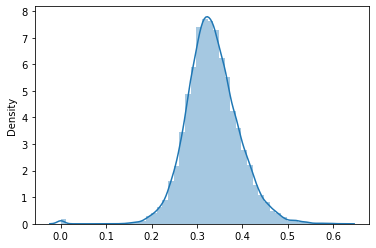

In [46]:
sns.distplot([score[1] for score in scores if type(score[1]) is float])

# Approach 3: Text Clustering

## Step 1: Create the documents for each ad

For each ad I want to create a document by combining the title, body and possibly the date posted fields. 
We will then compare each of the ads to eachother.

In [47]:
document_cols = [2,3,5,6,10,11,13]
hd['document'] = hd[hd.columns[document_cols]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
# hd

In [53]:
doc_list = hd['document'].to_list()


### Compute similarity between each ad using Semantic Textual Similarity

In [54]:
model = SentenceTransformer('paraphrase-MiniLM-L12-v2')

embeddings = model.encode(doc_list, convert_to_tensor=True)

cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

#cut cosine scores matrix in half because we only need half the matrix
# cosine_scores = []
# for i in range(len(cosine_scores)):
#     for j in range(i):
#         cosine_scores.append(cos_scores[i][:j]) 
        
# cos_scores.shape   



In [55]:
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index':[i,j], 'score': cosine_scores[i][j]})

pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

# for pair in pairs[0:10]:
#     i, j = pair['index']
#     print("I and J:" , i, j)
#     print("\n\n{} \t\t {} \t\t Score: {:.4f}".format(doc_list[i], doc_list[j], pair['score']))

In [56]:
# print ("cosine_scores:", cosine_scores) #matrix of cosine similarity scores between different ad documents

## Checking for validity by seeing what an 85% match looks like

In [61]:
pairs = set()
url_list = hd['url'].to_list()
print (len(url_list))
for i in range(len(cosine_scores)):
    for j in range(i):
        if cosine_scores[i][j] > .85 and (i,j) not in pairs:
            pairs.add((i,j))

# for pair in pairs:
#        print (url_list[pair[0]],",", url_list[pair[1]], "===")
# print (len(pairs))




202


In [64]:
def percent_match(url_list, lower_bound, upper_bound, cosine_scores):
    sim_ads = {}
    for i in range(len(cosine_scores)):
        ad_list = []
        for j in range(i):
            if cosine_scores[i][j] >= lower_bound and cosine_scores[i][j] <= upper_bound and i != j:
                ad_list.append(url_list[j])

#         print(ad_list)
        sim_ads[url_list[i]] = ad_list
    return sim_ads


    

def find_ad_group(sim_ads):
    ad_group = set() 

    for key, ad_list in sim_ads.items(): #go through dictionary and add adds with non empty values
        if ad_list:
            ad_group.add(key)
            for ads in ad_list:
                ad_group.add(ads)
    return len(ad_group), ad_group

#This prints out batch of ads that are between 80-84% match
sim_ads_75_80 = percent_match(url_list, .85, .9, cosine_scores)
# print(find_ad_group(sim_ads_75_80)[1])

# for ad in sim_ads_75_80:
#     if sim_ads_75_80[ad]:
#         print ("ad:", ad, ", pairs:", sim_ads_75_80[ad], "\n")

#This prints out batch of ads from 85%-100% match
# sim_ads_above_85 = percent_match(url_list, 85, 1, cosine_scores)




# print("Number of ads that shared at least and 85% match with another ad:", len_ad_group)
# print("Number of ads in the CSV:", len(url_list))
# print(len_ad_group, len(url_list))
# print("Percentage of ads with 50-60% match with another ad:", len_ad_group / len(url_list))



## Score Distribution for Textual Similarity

C:\Users\Elian\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

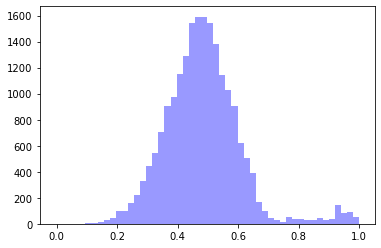

In [65]:
scores = []
for i in range(len(cosine_scores)):
    for j in range(i):
        if i == j: continue
        scores.append(cosine_scores[i][j])
# plot_scores = cosine_scores.flatten()
sns.distplot(scores, kde = False, color ='blue', bins = 50)

# Scoring System

Now that we have three different approaches we are going to create a scoring system which combines the distance, image comparison, and text clustering to deduce which ads are more likely to contain duplicates. As of right now I am weighting similarity between text at .6, similarity between images at .3, and distance at .1

In [67]:
text_scores = cosine_scores #cosine scores for textual semantic similarity -> already normalized
# distance_scores = np.linalg.norm(res, axis=0) #scores for distance from each ad to the other ad
img_scores = np.linalg.norm(scores, axis=0) #scores for image similarity between each ad

In [68]:
def final_scoring(F, I, T):
    """
    This method combines all the three scores from the distance scores matrix, 
    image scores matrix, text scores matrix and computes a final scores.
    F = empty final scores matrix 
    I = Image scores matrix
    T = text scores matrix 
    D = Distance Scores matrix
    """
    for i in range(len(F)):
        for j in range(len(F)):
            score = (I[i][j]*.2) + (T[i][j]*.8)
            F[i][j] = score
    return score

final_mat = np.eye(hd.shape[1]) #n x n matrix where n = number of ads
final_scores = final_scoring(final_mat, img_scores, text_scores)

IndexError: invalid index to scalar variable.

### Remove duplicate ads

In [ ]:
def remove_duplicates(F):
    """
    This method removes duplicate ads. The threshold for a duplicate ad is a score of .85 or above
    F - Final score matrix with comined scores
    """
    indices = set()
    for i in range(len(F)):
        for j in range(len(F)):
            if i == j:
                continue
            else:
                if F[i][j] >= .85:
                    indices.add(F[i][j])
    #remove 